In [12]:
import igraph as ig
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score
import numpy as np

In [13]:
# Eq (9.18) from the book
def mu_func(p_int, p_ext, Nc):
    k_ext = (p_ext*3*Nc)
    k_int = (p_int*(Nc-1))
    mu = k_ext / (k_ext+k_int)
    return mu

In [14]:
mu_v = []  # list of mu values
nmi_v = []  # list of nmi values
p_ext = np.arange(0, 0.8,0.05)  # list of p_ext values

In [15]:
len(p_ext)

16

In [ ]:
for i in p_ext:

    # GIRVAN-NEWMAN BENCHMARK --------------------------------------------------------------------

    # Parameters
    N = 128  # number of nodes
    p_int = 0.5  # probability of connecting to nodes of the same community
    p_ext = i  # probability of connecting to nodes from other

    Nc = N/4  # Size of each community

    #print("Parameters:")
    #print("N = ", N)
    #print("Nc = ", Nc)
    #print("p_int = ", p_int)
    #print("p_ext = ", p_ext)

    mu = mu_func(p_int, p_ext, Nc)
    mu_v.append(mu)
    print('Mu = ', mu, '    from Eq (9.18)\n')

    # Probabilities inter/intra communities
    pref_matrix = [[p_int, p_ext, p_ext, p_ext],
                   [p_ext, p_int, p_ext, p_ext],
                   [p_ext, p_ext, p_int, p_ext],
                   [p_ext, p_ext, p_ext, p_int]]

    block_sizes = [Nc, Nc, Nc, Nc]
    directed = False
    loops = False

    # Generating the graph with the community structure (GN-benchmark)
    # Reference: https://igraph.org/python/doc/api/igraph._igraph.GraphBase.html#SBM
    g = ig.Graph.SBM(N, pref_matrix, block_sizes, directed, loops)

    # Ground truth
    block = 1
    for i in range(g.vcount()):
        # To keep the real community label of each node
        g.vs[i]['comm'] = block
        if i != 0 and (i+1) % Nc == 0:
            block += 1

    # Coordinates to improve the network visualization:
    dist = 50
    step = 15
    x = 0
    y = 0
    block = 1
    layout = []
    for i in range(g.vcount()):
        layout.append((x+random.randint(0, step), y+random.randint(0, step)))

        if i != 0 and (i+1) % Nc == 0:
            if block % 2 == 1:
                x += dist
            else:
                x = 0
                y += dist
            block += 1
    # ----------------------------------------------------------------------------------------------

    # INFOMAP algorithm for community detection
    c = g.community_infomap()

    # number of communities
    nc = len(c)

    # COMPUTING THE NORMALIZED MUTUAL INFORMATION (Eq 9.19 from the Network Science book) -------------

    # We first create an array with the predicted community labels
    N = g.vcount()
    predicted_labels = np.zeros(N)
    print(c)
    for i in range(nc):
        # for each node in a community
        for v in c[i]:
            predicted_labels[v] = i

    # Ground truth according to the GN-benchmark
    ground_truth = np.array(g.vs['comm'])

    # Now we compare the predicted labels with the ground truth using the Normalized Mutual Information
    NMI = normalized_mutual_info_score(ground_truth, predicted_labels)
    nmi_v.append(NMI)
    print("\nNormalized mutual information: ", NMI)

    # ------------------------------------------------------------------------------------------------

    # Plotting

    # List of matplotlib colors
    # colors = list(mcolors.CSS4_COLORS)

    # Same color to the members of a community
    # for i in range(nc):
    # 	g.vs[c[i]]['color'] = colors[i]

    # visual_style = {}
    # visual_style['color'] = g.vs['color']
    # ig.plot(g, layout=layout, **visual_style)

Text(0.5, 1.0, 'GN Benchmark')

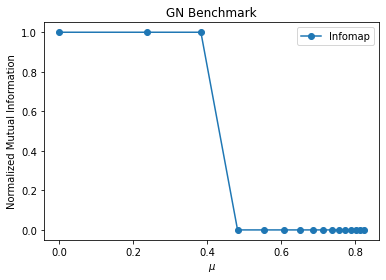

In [31]:
plt.plot(mu_v, nmi_v,'-o',label='Infomap')
plt.xlabel('$\mu$')
plt.legend()
plt.ylabel('Normalized Mutual Information')
plt.title('GN Benchmark')